# Multi Layer Perceptron NLP Model by Bengio, Part 3

This is an implementation of a character level NLP model, motivated by [Bengio et al.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper, based on Andrej Karpathy's [Makemore](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3) lectures.

<br>
<br>
<figure align="center">
    <img src="./images/bengio_2003_neural_architecture.png" width="500">
    <figcaption>Bengio et al.'s neural model.</figcaption>
</figure>

, where $w_t$ is the t-th word, and $w_i^j = \left(w_i, w_{i+1}, \ldots, w_{j-1}. w_j\right)$ is a sequence of words from $i$ to $j$. Since in this example we will teach a neural network to generate names based on examples, instead of using words, we use characters. This version mimics some of PyTorche's layers while implementing the model. Visualises the following:

* Activation distribution
* Gradient distribution
* Weight gradient distribution
* Update to weight ratio $\dfrac{lr \cdot \nabla}{weight}$, where $lr$ is the learning rate and $\nabla$ is the gradient

## Input to the Model

The input to the model is a sequence of n-characters (we use 3 in the code). These characters are converted into a 2D embedding space using a look-up-table C. LUT is part of the nn model, so the weights for the LUT are learned. The rationale for using a learned embedding space is for the model to be able to generalize better, especially when it comes across input that is has not seen previously.

## Output from the Model 

For each combination of 3 input characters, the model outputs a probability distribution for the 27 letters from the alphabet. Using the probability distribution we can sample letters.

## Loss Function

We need a way of measuring how well the model is doing so that the deep-learning model can learn based on the given examples. In order to do so, we need a loss function. We start by defining the likelihood function. Likelihood function is the joint probability of the observed data viewed as a function of the parameters of a statistical model (source: [Wikipedia](https://en.wikipedia.org/wiki/Likelihood_function)). In statistics, maximum likelihood estimation is a method of estimating the parameters of an assumed probability distribution, given observed data. For a set of independent and identically distributed points $X = \{x_1, x_2,..., x_n\}$, the likelihood is defined as follows:

$$\mathcal{L}(\theta|x)=p(X|\theta)=\prod_{n=1}^{N}p(x_n|\theta)$$

$\mathcal{L}(\theta|x)$ is the likelihood function, $\theta$ are the model parameters and $x$ are the observations. We want to maximize the likelihood of the data with respect to the parameters. In other words, we want to maximize the likelihood, by tweaking the parameters $\theta$, that the model produces the observed data. Since we have many bigrams, we want to maximize the likelihood over all of them, which leads to a product over all of the probabilities. Since the probability for each individual observation is between $[0...1]$, multiplying these together leads to a small number and numerical instabilities. Therefore, we want to maximize the log-likelihood. Since $log(a \cdot b)=log(a)+log(b)$, we get:

$$log\left(\mathcal{L}(\theta|x)\right)=\sum_{n=1}^{N}log\left(p(x_n|\theta)\right)$$

The way we train deep-learning networks is by minizing a loss function. Maximizing the log-likelihood is equivalent to minimizing the negative log-likelihood, and in order for the results to be comparable regardless the number of data points we are using, we normalize the negative log-likelihood by dividing it with the number of data points we have. Therefore, our loss function is:

$$-\dfrac{1}{N}\sum_{n=1}^{N}log\left(p(x_n|\theta)\right)$$

In [1]:
import urllib.request
import torch
import torch.nn as nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Url to the file containing over 30k names
url_source = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

text = str('')

# Read to a variable, line by line
for line in urllib.request.urlopen(url_source):
    text += line.decode('utf-8')

In [3]:
# Split the file to lines and show the first 10 lines
words = text.splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
# Create the dictionaries to map characters to integers and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(f"{stoi=}")
print(f"{itos=}")

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Training the Model

In [5]:
block_size = 3 # how many characters we use in order to predict the next one

def build_dataset(words_in, block_size_in=3):
    
    X, Y = [], []

    for w in words_in:
        # This creates a list, filled with zeros:, that has the length defined by the variable block_size
        context = [0] * block_size_in
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

In [6]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    """_summary_
    """

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers, updated with momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        if self.training:
            xmean = x.mean(1, keepdim=True)
            xvar = x.var(1, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Output from the network
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1.0-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1.0-self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

## Without Batch Normalisation

This example composes a NN that has several layers with linear- and tanh- layers, but without batch normalisation. The weights are initialised so that everything should more or less work, but by changing the weight initialisation, backpropagation can be messy. Gradients etc. are visualised after the training, so effects of initialisation on the gradients etc. can be visualised nicely.

In [7]:
embedding_size = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons on the hidden layers
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), generator=g)
layers = [
    Linear(embedding_size*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # Last layer, make less confident
    layers[-1].weight *= 0.1
    # All other layers, apply gain
    # Tanh-function is a 'squashing' function, i.e. it squahes the outputs. When you have
    # several linear layers, coupled with tanh-layers, every consecuent layer in the output
    # gets more 'squashed'. Therefore, we apply gain to the layers in order to spread them out.
    # You can change the gain, and see the effect on the saturation of the tanh-layers down below.
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

172697


In [8]:
losses = np.array([])
update_to_data_ratio = []

In [9]:
batch_size = 128
max_steps = 1000

for k in range(max_steps):
    
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #--- FORWARD PASS ---
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    
    for layer in layers:
        x = layer(x)
    loss = torch.nn.functional.cross_entropy(x, Yb)
    losses = np.append(losses, loss.log10().item())

    #--- BACKWARD PASS ---
    for layer in layers:
        layer.out.retain_grad()
    
    # Reset the gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate
    lr = 0.1 if k < 20000 else 0.005

    # update the weights
    for p in parameters:
        p.data += -lr * p.grad
    
    with torch.no_grad():
        update_to_data_ratio.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if k % 1000 == 0:
        print(f"{k:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/   1000: 3.2991


layer (1: Tanh): mean: 0.05, std: 0.76, saturated: 20.77%
layer (3: Tanh): mean: 0.02, std: 0.71, saturated: 10.87%
layer (5: Tanh): mean: -0.03, std: 0.70, saturated: 9.91%
layer (7: Tanh): mean: 0.01, std: 0.70, saturated: 9.64%
layer (9: Tanh): mean: 0.04, std: 0.70, saturated: 8.71%


[]

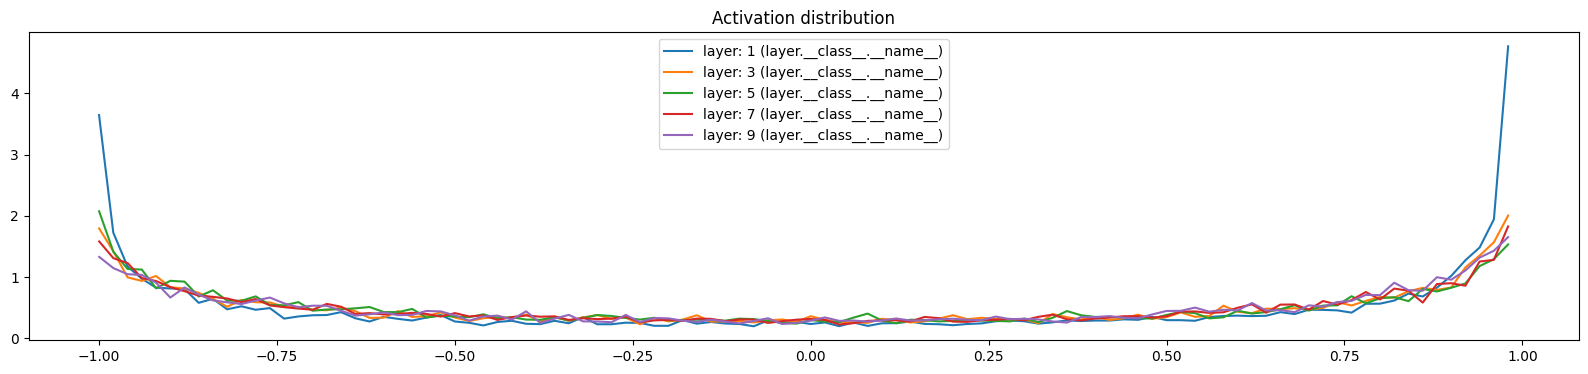

In [10]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer ({i}: {layer.__class__.__name__}): mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer: {i} (layer.__class__.__name__)")
plt.legend(legends)
plt.title('Activation distribution')
plt.plot()

layer (1: Tanh): mean: 0.0000063535, std: 0.0006755934
layer (3: Tanh): mean: -0.0000039404, std: 0.0006607551
layer (5: Tanh): mean: 0.0000017710, std: 0.0006274088
layer (7: Tanh): mean: 0.0000036868, std: 0.0005423008
layer (9: Tanh): mean: -0.0000015315, std: 0.0004237653


[]

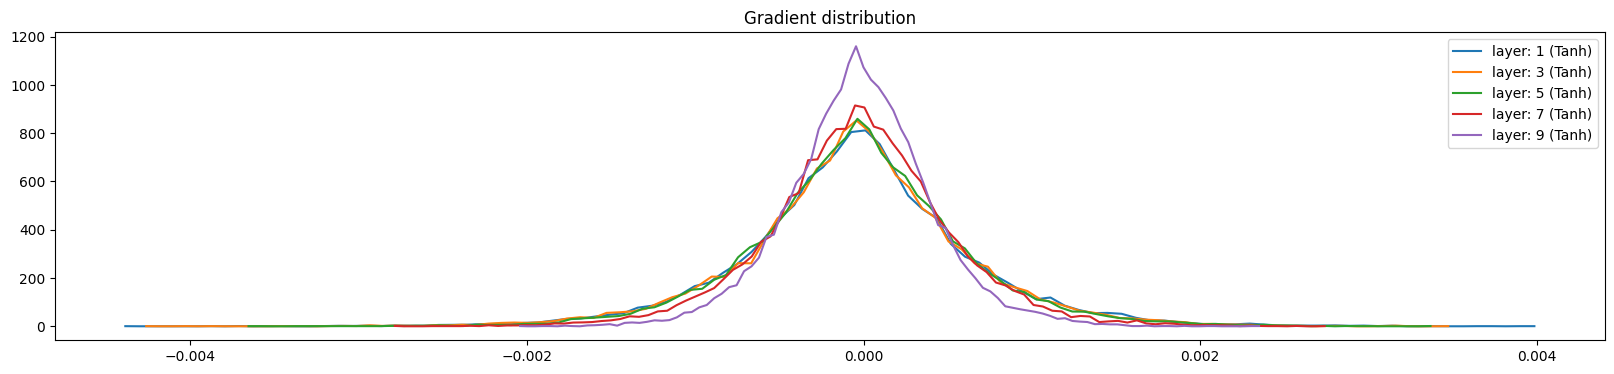

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer ({i}: {layer.__class__.__name__}): mean: {t.mean():.10f}, std: {t.std():.10f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer: {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('Gradient distribution')
plt.plot()

weight (27, 10) | mean 0.0003188 | std 0.0071767 | grad:data ratio 0.0071713
weight (30, 200) | mean -0.0000465 | std 0.0042822 | grad:data ratio 0.0137731
weight (200, 200) | mean -0.0000016 | std 0.0034868 | grad:data ratio 0.0294302
weight (200, 200) | mean 0.0000111 | std 0.0030737 | grad:data ratio 0.0259596
weight (200, 200) | mean -0.0000305 | std 0.0026741 | grad:data ratio 0.0224765
weight (200, 200) | mean -0.0000001 | std 0.0020537 | grad:data ratio 0.0173700
weight (200, 27) | mean -0.0000000 | std 0.0119222 | grad:data ratio 0.2398820


[]

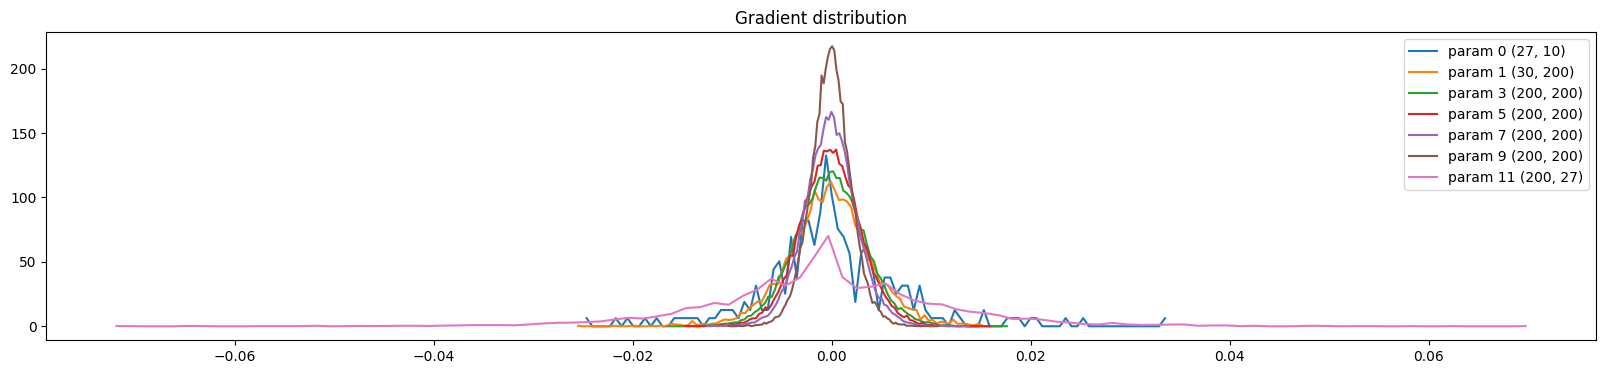

In [12]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {tuple(p.shape)} | mean {t.mean():.7f} | std {t.std():.7f} | grad:data ratio {t.std()/p.std():.7f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"param {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('Gradient distribution')
plt.plot()

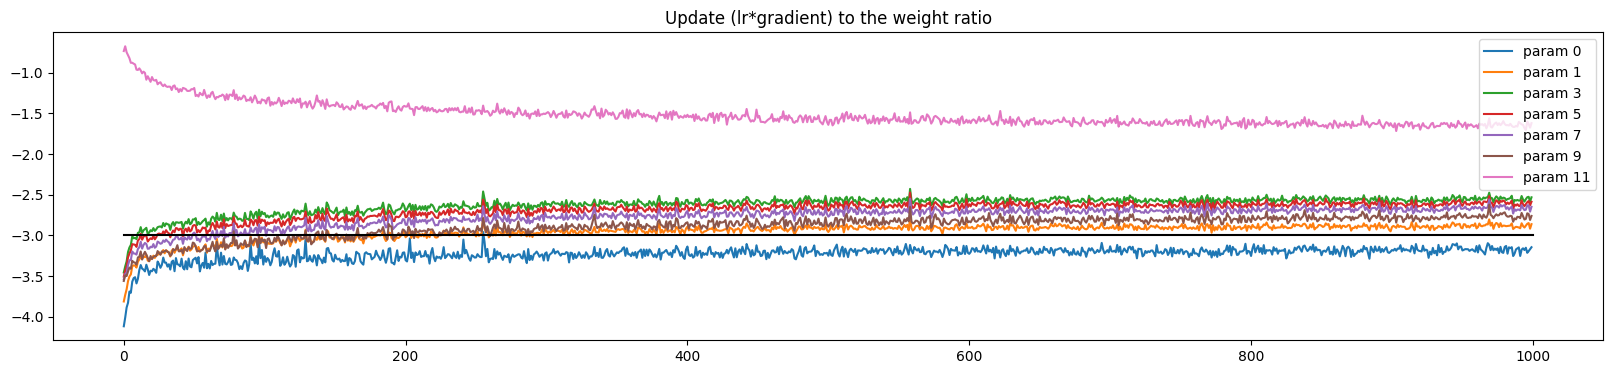

In [13]:
# Here we plot the update (lr*gradient) to weight ratio for each iteration. This tells us the rate at
# which the weights are being updated. In general, each layer should have similar ratios, around 1e-3
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f'param {i}')
plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be around 1e-3
plt.legend(legends)
plt.title("Update (lr*gradient) to the weight ratio")
plt.show()

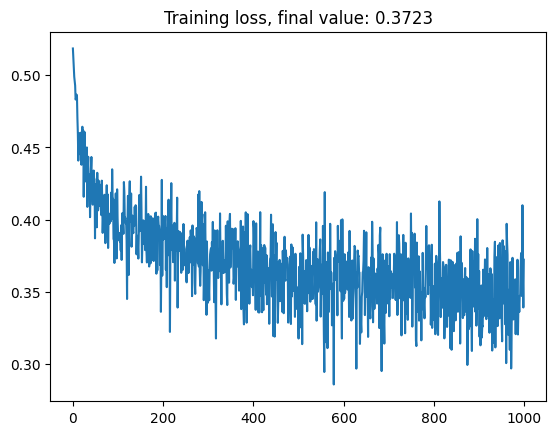

In [14]:
plt.plot(losses)
plt.title(f'Training loss, final value: {losses[-1].item():.4f}')
plt.show()

## With Batch Normalisation

In [48]:
embedding_size = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons on the hidden layers
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), generator=g)
layers = [
    Linear(embedding_size*block_size, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # Last layer, make less confident
    layers[-1].gamma *= 0.1
    # All other layers, apply gain
    # Tanh-function is a 'squashing' function, i.e. it squahes the outputs. When you have
    # several linear layers, coupled with tanh-layers, every consecuent layer in the output
    # gets more 'squashed'. Therefore, we apply gain to the layers in order to spread them out.
    # You can change the gain, and see the effect on the saturation of the tanh-layers down below.
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

173724


In [49]:
losses = np.array([])
update_to_data_ratio = []

In [50]:
batch_size = 128
max_steps = 3000

for k in range(max_steps):
    
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #--- FORWARD PASS ---
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    
    for layer in layers:
        x = layer(x)
    loss = torch.nn.functional.cross_entropy(x, Yb)
    losses = np.append(losses, loss.log10().item())

    #--- BACKWARD PASS ---
    for layer in layers:
        layer.out.retain_grad()
    
    # Reset the gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate
    lr = 0.1 if k < 20000 else 0.05

    # update the weights
    for p in parameters:
        p.data += -lr * p.grad
    
    with torch.no_grad():
        update_to_data_ratio.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if k % 1000 == 0:
        print(f"{k:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/   3000: 3.3043
   1000/   3000: 2.2879
   2000/   3000: 2.1847


layer (2: Tanh): mean: -0.01, std: 0.63, saturated: 3.38%
layer (5: Tanh): mean: 0.00, std: 0.63, saturated: 4.34%
layer (8: Tanh): mean: -0.00, std: 0.64, saturated: 4.18%
layer (11: Tanh): mean: 0.00, std: 0.64, saturated: 4.14%
layer (14: Tanh): mean: 0.00, std: 0.65, saturated: 3.68%


[]

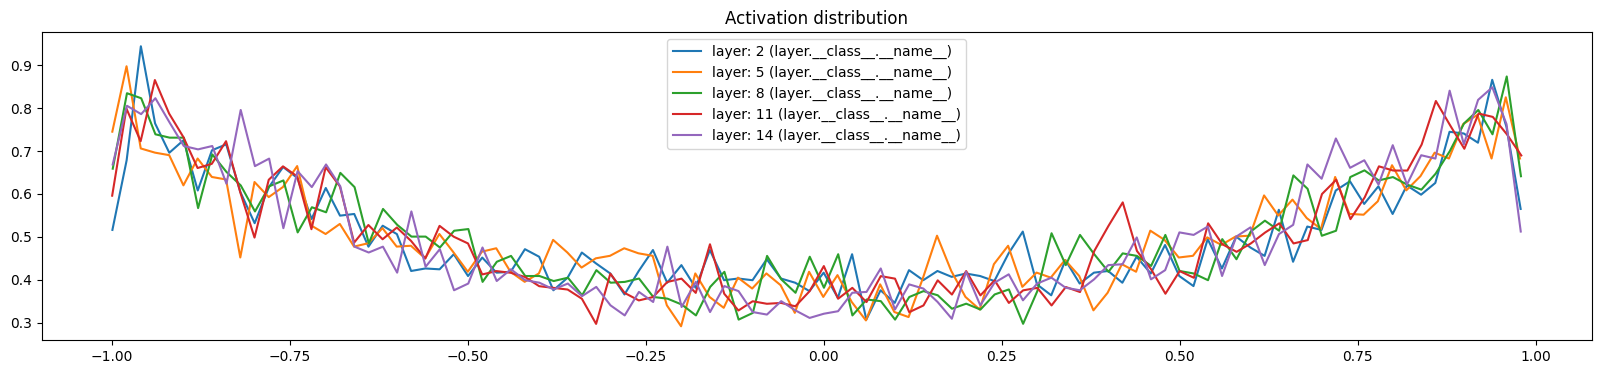

In [51]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer ({i}: {layer.__class__.__name__}): mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer: {i} (layer.__class__.__name__)")
plt.legend(legends)
plt.title('Activation distribution')
plt.plot()

layer (2: Tanh): mean: 0.0000010967, std: 0.0008451285
layer (5: Tanh): mean: 0.0000014215, std: 0.0007627037
layer (8: Tanh): mean: 0.0000035686, std: 0.0007700704
layer (11: Tanh): mean: -0.0000010702, std: 0.0007288677
layer (14: Tanh): mean: -0.0000021735, std: 0.0006956701


[]

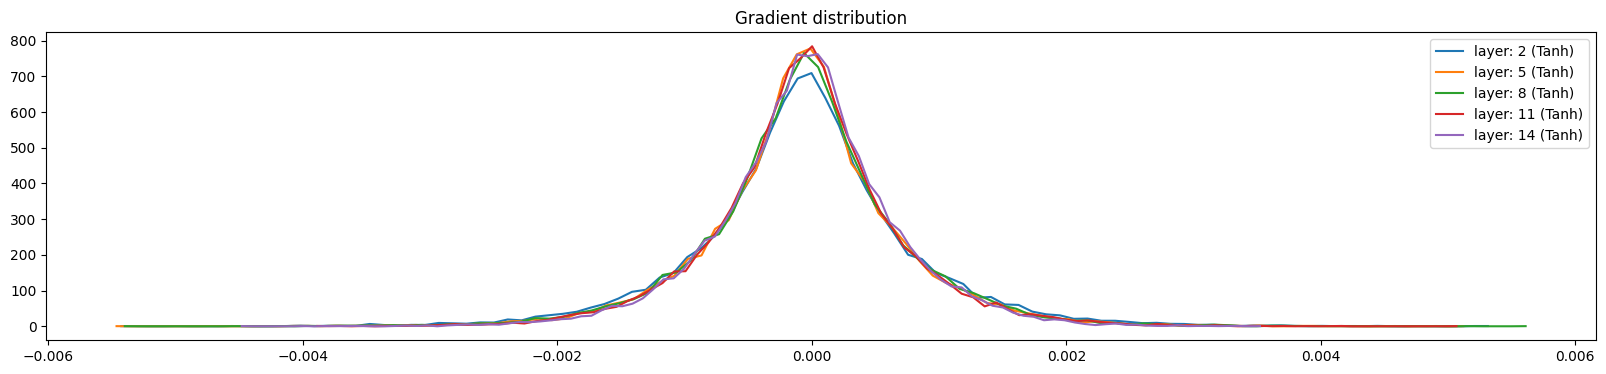

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer ({i}: {layer.__class__.__name__}): mean: {t.mean():.10f}, std: {t.std():.10f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer: {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('Gradient distribution')
plt.plot()

weight (27, 10) | mean -0.0001433 | std 0.0062195 | grad:data ratio 0.0062119
weight (30, 200) | mean 0.0000000 | std 0.0040039 | grad:data ratio 0.0128612
weight (200, 200) | mean -0.0000000 | std 0.0034827 | grad:data ratio 0.0292474
weight (200, 200) | mean 0.0000000 | std 0.0032220 | grad:data ratio 0.0271184
weight (200, 200) | mean -0.0000000 | std 0.0030853 | grad:data ratio 0.0258578
weight (200, 200) | mean -0.0000000 | std 0.0029052 | grad:data ratio 0.0245128
weight (200, 27) | mean -0.0000000 | std 0.0078485 | grad:data ratio 0.0627824


[]

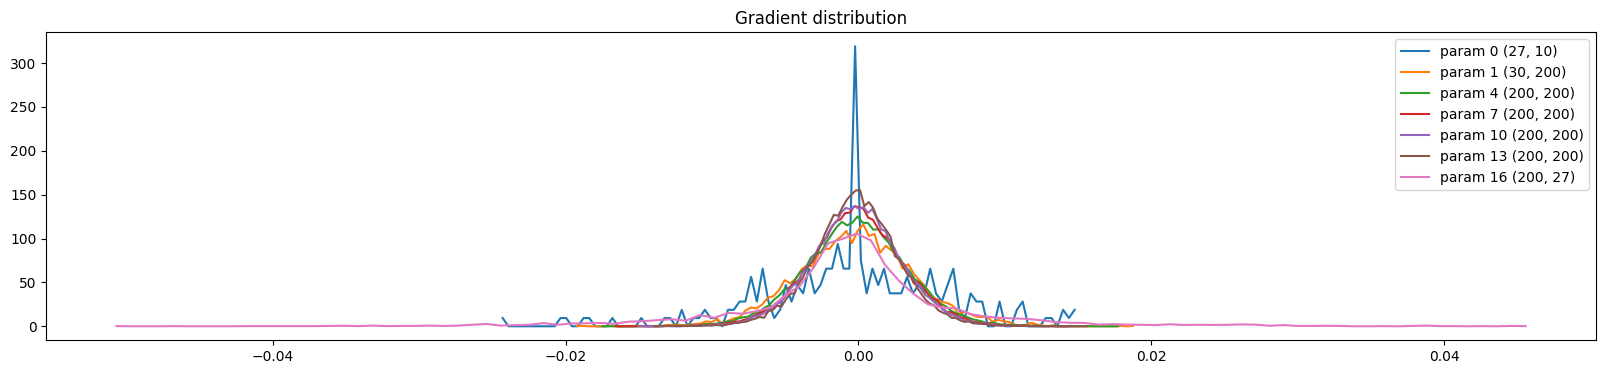

In [53]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {tuple(p.shape)} | mean {t.mean():.7f} | std {t.std():.7f} | grad:data ratio {t.std()/p.std():.7f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"param {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('Gradient distribution')
plt.plot()

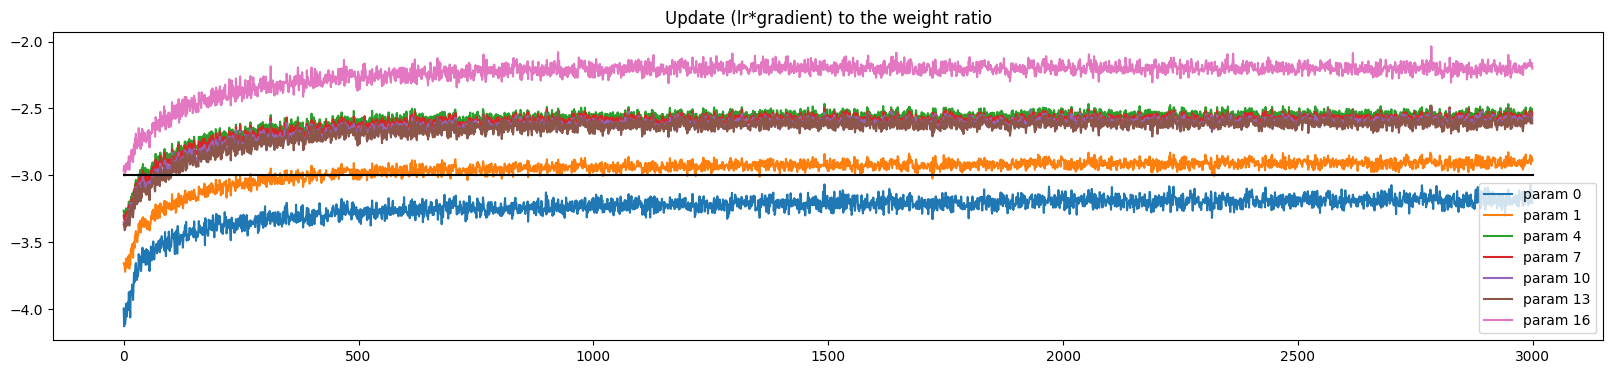

In [54]:
# Here we plot the update (lr*gradient) to weight ratio for each iteration. This tells us the rate at
# which the weights are being updated. In general, each layer should have similar ratios, around 1e-3
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f'param {i}')
plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be around 1e-3
plt.legend(legends)
plt.title("Update (lr*gradient) to the weight ratio")
plt.show()